In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/jupyter')
sys.path.append('/home/jupyter/checkmate-histo')
from checkmate_imports import *

# global variables 
HUE_ORDER = ['stroma','pred_g2','intermediate_grade','pred_g4']
MIN_SEGMENT_SIZE = 50
GRADE_DIFF_THRESH = 0.35
TUMOR_DIFF_THRESH = 0.35
MIN_TUMOR_SEG_MEAN = 0.70
NODE_DIFF_CUTOFF = invert_rag_weight(GRADE_DIFF_THRESH) 
MIN_TIL_COUNT = 10

# GRADE_TC_CUTOFF = 0.4  # minimum segment mean grade score to consider in TIL processing 
# GRADE_TC_CUTOFF = 0.  # minimum segment mean grade score to consider in TIL processing 
GRADE_TC_CUTOFF = 0.8  # focusing on high grade foci only 

print('MODIFYING EARLIER TIL CUTOFFS')
TIL_ISO_CUTOFF = 14  # based on none vs any AUROC bootstrap on high grade foci + no hard cases
TIL_HIGH_CUTOFF = 48 # based on not-high vs high AUROC bootstrap on high grade foci + no hard cases
FRAC_CUTOFF = 0.25
TIL_AREA_CUTOFF = 10

EXCLUSION_RATIO_CUTOFF = 1.5  # margin vs center ratio threshold for "exclusion" call
TILES_PER_MM2 = 0.256**-2

# assume 7x7 minimum case for a square area focus
# going 2 tiles inner would result in a 5x5 inner cube and thus area cutoff of 25
# MIN_CENTER_AREA = 25
MIN_CENTER_AREA = 10  # relaxing from 25 to try to recover possible interesting foci

MODIFYING EARLIER TIL CUTOFFS


In [2]:
# from statannotations.Annotator import Annotator
# from statannot import add_stat_annotation
from itertools import combinations, product

### Load saved files

In [6]:
mounted_jupyter = '/mnt/disks/image_data/denize_multislide_raw/sgpu2_jupyter_clone_20220609/jupyter/checkmate-histo/consolidated_workflow/multislide_analysis/'
tilewise_nontil_info = pd.read_csv(mounted_jupyter+'denize_multi_passing_twostage_segmentation_tile_level_info.csv', index_col=0)

#### Gather two-stage watershed outputs from generic runner
- `full_rerun_all_cohorts_seg_rerun_070_tumor_segmean.py`: Generation of two-stage segmentation labels

In [7]:
seg_outs = {}
for cohort in ['denize_multi']:
    seg_outs[cohort] = torch.load(mounted_jupyter+f'{cohort}_twostage_watershed_out_rerun.pkl')

seg_out_agg = {}
failed_ids = []
failed_data_agg = {}
for cohort, seg_out_data in seg_outs.items():
    for entry in seg_out_data:
        try:
            unique_id = entry['unique_id']
            seg_out_agg[unique_id] = entry
        except:
            uid = entry['seg_df']['unique_id'].unique()[0]
            failed_ids.append(uid)
            failed_data_agg[uid] = entry['seg_df']

#### Aggregate RAG edge information 

In [8]:
# run_two_stage_watershed_segmentation??

In [9]:
rag_type = 'premerge_expansion_rags'

# initially based on 20210513 NB on pivoting to get counts of edge types
count_store = []
weighted_edge_info_store= []
merged_descriptions = []
node_summaries = {}
processed_graphs = {}


for uid, outs in seg_out_agg.items():
    rags = deepcopy(outs[rag_type])
    rags[0] = outs['rag']

    for dist, entry in rags.items():
        g = entry.copy()
        g = post_process_seg_graph_simplified(g, uid, MIN_SEGMENT_SIZE, NODE_DIFF_CUTOFF)
        
        if dist == 0: # store info derived from base graph only; we only need the others for edge related info
            processed_graphs[uid] = g
            node_summaries[uid] = summarize_nodes(g, outs['seg_df'])

        if len(g.edges) > 0:
            edge_desc = pd.DataFrame({k:v for k,v in g.edges.items()}).transpose()
            edge_desc.index = edge_desc.index.set_names(['edge0','edge1'])
            edge_desc['unique_id'] = uid
            edge_desc['expansion_dist'] = dist
            weighted_edge_info_store.append(reset_set_idx(edge_desc, ['unique_id','expansion_dist','edge0','edge1']))
        
weighted_edge_info_store = pd.concat(weighted_edge_info_store)
weighted_edge_info_store['min_node_area'] = weighted_edge_info_store[['node0_tumor_area_frac','node1_tumor_area_frac']].min(1)
weighted_edge_info_store['edge_set'] = weighted_edge_info_store.reset_index()[['edge0','edge1']].apply(lambda x: set(x),1).values

In [10]:
weighted_edge_info_store.shape

(767, 8)

#### Aggregate RAG edges into "proximal" vs "distal" categories
- Collapse default and expansion distance 1 into "proximal"
- Collapse expansion distance 10 & 25 into "distal"

In [11]:
edge_class_agg = []
for uid in weighted_edge_info_store.index.levels[0]:
    ex_out = seg_out_agg[uid]
    seg_df = ex_out['seg_df']
    edge_subset = weighted_edge_info_store.loc[[uid]]
    edge_subset = check_label_set_df(seg_df, edge_subset)
    edge_class_agg.append(edge_subset)
    
edge_class_agg = pd.concat(edge_class_agg)

# fix object dtype assignment
for col in edge_class_agg.columns:
    try:
        edge_class_agg[col] = edge_class_agg[col].astype(float)
    except:
        pass

edge_class_agg_pivot = edge_class_agg.reset_index().pivot_table(index=['unique_id','edge0','edge1','passing_edge'], columns='expansion_dist', values='diff')
edge_class_agg_pivot = edge_class_agg_pivot.reset_index(level=3)
edge_class_agg_pivot['passing_edge'] = edge_class_agg_pivot['passing_edge'].astype(bool)
edge_class_agg_pivot.loc[edge_class_agg_pivot.passing_edge, 'edge_class'] = edge_class_agg_pivot.loc[edge_class_agg_pivot.passing_edge].apply(lambda x: classify_distal_vs_proximal_edge(x), 1)
edge_class_agg_pivot['edge_class'] = edge_class_agg_pivot['edge_class'].fillna('not_eligible')

edge_class_sum = pd.get_dummies(edge_class_agg_pivot, columns=['edge_class']).groupby('unique_id').sum()

In [12]:
edge_agg = []
for uid in weighted_edge_info_store.index.levels[0]:
    try:
        seg_df = tilewise_nontil_info.loc[[uid]]
        edge_subset = weighted_edge_info_store.loc[[uid]]
        edge_subset = check_label_set_df(seg_df, edge_subset)
        edge_agg.append(edge_subset)
    except:
        print(f'{uid} failed to aggregate')

edge_agg = pd.concat(edge_agg)

# fix object dtype assignment
for col in edge_agg.columns:
    try:
        edge_agg[col] = edge_agg[col].astype(float)
    except:
        pass

#### Call Proximal vs Distal Edges & Sum

In [13]:
edge_agg_pivot = edge_agg.reset_index().pivot_table(index=['unique_id','edge0','edge1','passing_edge'], columns='expansion_dist', values=['diff','tumor_area_frac_sum'])
edge_agg_pivot = edge_agg_pivot.reset_index(level=3)
edge_agg_pivot['passing_edge'] = edge_agg_pivot['passing_edge'].astype(bool)
edge_agg_pivot['edge_class'] = edge_agg_pivot['diff'].apply(lambda x: classify_distal_vs_proximal_edge(x), 1)
edge_agg_pivot.loc[~edge_agg_pivot['passing_edge'], 'edge_class'] = 'not_eligible'
edge_agg_pivot['edge_class'] = edge_agg_pivot['edge_class'].fillna('not_eligible')

edge_class_sum = pd.get_dummies(edge_agg_pivot, columns=['edge_class']).groupby('unique_id').sum()

#### Get Segment-Wise Mean Info

In [14]:
segmentwise_mean = tilewise_nontil_info.loc[tilewise_nontil_info.meta !='stroma'].groupby(['unique_id','merged_labels']).mean()

#### Get Side-Wise Mean Info

In [15]:
slidewise_mean = tilewise_nontil_info.loc[tilewise_nontil_info.meta !='stroma'].groupby(['unique_id']).mean()

#### Add node0/1 annotations to each edge 

In [16]:
all_seg_counts = tilewise_nontil_info.loc[tilewise_nontil_info['meta'] == 'tumor'].value_counts(subset=['unique_id','merged_labels'])
all_seg_counts.name = 'seg_size'
all_seg_counts = pd.DataFrame(all_seg_counts).join(segmentwise_mean[['smoothed_prob_tumor','smoothed_prob_g4_not_g2']]) # add segment mean tumor and grade score
all_seg_counts = all_seg_counts.reset_index()
all_seg_counts['seg_area_frac'] = all_seg_counts.groupby(['unique_id']).seg_size.apply(lambda x: x/x.sum())
all_seg_counts['merged_labels'] = all_seg_counts['merged_labels'].astype(int)

edge_agg_pivot = edge_agg_pivot.reset_index(level=1)
edge_agg_pivot.index.set_names('merged_labels',level=1, inplace=True)
edge_agg_pivot = edge_agg_pivot[['edge0','edge_class']]
edge_agg_pivot.columns = [' '.join(col).strip() for col in edge_agg_pivot.columns.values]

# add node 1 info 
edge_agg_pivot = edge_agg_pivot.join(all_seg_counts.set_index(['unique_id','merged_labels'])).rename(columns={
    'seg_area_frac':'node1_area_frac', 'smoothed_prob_g4_not_g2':'node1_grade_score','smoothed_prob_tumor':'node1_tumor_score',
})
# edge_agg_pivot = edge_agg_pivot.join(til_context_agg).rename(columns={x:'node1_'+x for x in til_context_agg.columns})

edge_agg_pivot.index.set_names('edge1',level=1, inplace=True)
edge_agg_pivot = reset_set_idx(edge_agg_pivot, ['unique_id','edge0'])
edge_agg_pivot.index.set_names('merged_labels',level=1, inplace=True)

# add node 0 info 
edge_agg_pivot = merge_nonoverlapping(edge_agg_pivot, all_seg_counts.set_index(['unique_id','merged_labels'])).rename(columns={
    'seg_area_frac':'node0_area_frac' ,'smoothed_prob_g4_not_g2':'node0_grade_score','smoothed_prob_tumor':'node0_tumor_score',
})
# edge_agg_pivot = edge_agg_pivot.join(til_context_agg).rename(columns={x:'node0_'+x for x in til_context_agg.columns})

edge_agg_pivot.index.set_names('edge0',level=1, inplace=True)
edge_agg_pivot = reset_set_idx(edge_agg_pivot, ['unique_id','edge0','edge1'])

#### Add an F1 style measure of the node area fractions 
- If close to 1, it's a balanced edge; closer to 0 implies one of the nodes is much smaller

In [17]:
edge_agg_pivot['edge_pair_area'] = edge_agg_pivot['node0_area_frac'] + edge_agg_pivot['node1_area_frac']
edge_agg_pivot['min_node_area_in_edge'] = edge_agg_pivot[['node0_area_frac', 'node1_area_frac']].apply(min, 1)

ec_recover = edge_agg_pivot['edge_class'].copy()
edge_agg_pivot = pd.get_dummies(edge_agg_pivot, columns=['edge_class'])
edge_agg_pivot['edge_class'] = ec_recover

edge_agg_pivot['area_fmeasure'] = 4*(edge_agg_pivot['node0_area_frac']*edge_agg_pivot['node1_area_frac'])/(edge_agg_pivot['node0_area_frac']+edge_agg_pivot['node1_area_frac'])

edge_agg_pivot['edge_class_distal_min_weighted'] = edge_agg_pivot['min_node_area_in_edge'] * edge_agg_pivot['edge_class_distal']
edge_agg_pivot['edge_class_proximal_min_weighted'] = edge_agg_pivot['min_node_area_in_edge'] * edge_agg_pivot['edge_class_proximal']

edge_agg_pivot['edge_class_distal_total_weighted'] = edge_agg_pivot['edge_pair_area'] * edge_agg_pivot['edge_class_distal']
edge_agg_pivot['edge_class_proximal_total_weighted'] = edge_agg_pivot['edge_pair_area'] * edge_agg_pivot['edge_class_proximal']

edge_agg_pivot['edge_class_distal_f_weighted'] = edge_agg_pivot['area_fmeasure'] * edge_agg_pivot['edge_class_distal']
edge_agg_pivot['edge_class_proximal_f_weighted'] = edge_agg_pivot['area_fmeasure'] * edge_agg_pivot['edge_class_proximal']

edge_agg_pivot = edge_agg_pivot.dropna(subset=['node1_area_frac','node0_area_frac'])

edge_agg_pivot['min_tumor_score'] = edge_agg_pivot[['node0_tumor_score','node1_tumor_score']].min(1)
# print(edge_agg_pivot.shape)
# print('dropping edges where one or more nodes drop below min. tumor score (0.7)')
# edge_agg_pivot = edge_agg_pivot.loc[edge_agg_pivot['min_tumor_score'] >= MIN_TUMOR_SEG_MEAN]
# print(edge_agg_pivot.shape)

edge_class_sum = edge_agg_pivot.iloc[:,5:].groupby('unique_id').sum()

In [18]:
# edge_agg_pivot.loc[edge_agg_pivot['edge_class'] != 'not_eligible'][['seg_size','node0_tumor_score','node1_tumor_score','edge_class']].sample(25).sort_values('edge_class')

In [19]:
import parse

template = 'JACKSON CASE {case_num} SLIDE {block_num}_Scan1'
parse.parse(template, tilewise_nontil_info.index.values[0]).named
case_key = pd.DataFrame({x:parse.parse(template, x).named for x in tilewise_nontil_info.index.unique()}).transpose()
case_key.index.name = 'unique_id'

tilewise_nontil_info = tilewise_nontil_info.join(case_key)
tilewise_nontil_info[['case_num','block_num']] = tilewise_nontil_info[['case_num','block_num']].astype(int)
case_key[['case_num','block_num']] = case_key[['case_num','block_num']].astype(int)

In [20]:
MIN_SLIDES = 3
MIN_TILES = 200

In [21]:
edge_class_sum['combined_edge_total'] = edge_class_sum['edge_class_proximal'] + edge_class_sum['edge_class_distal'] 

In [29]:
mounted_jupyter = '/mnt/disks/image_data/denize_multislide_raw/sgpu2_jupyter_clone_20220609/jupyter/checkmate-histo/consolidated_workflow/multislide_analysis/'
tilewise_nontil_info = pd.read_csv(mounted_jupyter+'denize_multi_passing_twostage_segmentation_tile_level_info.csv', index_col=0)

# rag_inspection NB
dm = pd.read_csv(mounted_jupyter+'denize_multi_case_level_features.csv',index_col=0)
dm['grade_score'] = dm['smoothed_prob_g4_not_g2']

dm['fhs'] = dm['combined_het_score_f_weighted']
dm['ths'] = dm['combined_het_score_total_weighted']
dm['gs'] = dm['grade_score']


## case level aggregations
het_counts = dm.groupby(['case_num'])['any_diff_edge'].sum()
het_counts.name = 'het_count'

het_freq = dm.groupby(['case_num'])['any_diff_edge'].mean()
het_freq.name = 'het_freq'

block_counts = dm.value_counts('case_num')
block_counts.name = 'block_count'

In [30]:
MIN_SLIDES = 3
passing_case_nums = get_indices(dm.dropna(subset=['combined_het_score_f_weighted']).value_counts('case_num') >= MIN_SLIDES)

nonhomog = dm.loc[passing_case_nums].copy().reset_index()
nonhomog = nonhomog.loc[nonhomog['any_diff_edge']]

In [31]:
nonhomog.loc[nonhomog['fhs'] > 0.8, ['case_num','block_num']].sample(5)

,case_num,block_num
62,23,2
87,11,1
63,23,3
34,26,5
10,10,10


In [32]:
nonhomog.loc[(nonhomog['fhs'] < 0.6) & (nonhomog['fhs'] > 0), ['case_num','block_num']].sample(5)

,case_num,block_num
42,19,3
64,23,5
90,22,1
0,7,10
5,7,4


In [ ]:
            try:
                uid = case_key.loc[(case_key['case_num'] == case_num) & (case_key['block_num'] == block_num)].index.values[0]
                ex_out = seg_out_agg[uid]
                input_df = ex_out['seg_df']
                heatmap = get_separated_heatmaps_simplified(input_df.reset_index().rename(columns={'tx':'x', 'ty':'y'}), col='smoothed_prob_tumor')

                axes[0,idx].imshow(heatmap)
                axes[0,idx].axis('off')

                mod_im = np.ma.masked_array(ex_out['seg_images']['all'], mask = np.isnan(ex_out['seg_images']['all'])).filled(0)
                mod_labels = np.ma.masked_array(ex_out['seg_out']['merged_labels'], mask = np.isnan(ex_out['seg_images']['all'])).filled(ex_out['seg_out']['merged_labels'].max()+1)
                label_clone = mod_labels.copy()

                if uid in edge_agg_pivot.index.levels[0].unique():
                    filtered_rags = prepare_distal_rag(seg_out_agg[uid], uid, edge_agg_pivot.loc[uid], min_segment_size=MIN_SEGMENT_SIZE)
                    for edge_type in ['proximal','distal']:
                        ax = axes[1,idx]
                        rag = filtered_rags[f'g_{edge_type}'].copy()
                        img_cmap='Reds_r'


                        g = rag.copy()
                        to_remove = []
                        for node_name in g.nodes:
                            if g.nodes[node_name]['pixel count'] < MIN_SEGMENT_SIZE:
                                to_remove.append(node_name)
    #                             print(f'removing {node_name}')
                        for node_name in to_remove:
                            g.remove_node(node_name)

                        overlay_copy = np.copy(mod_im)
                        overlay_copy[~((label_clone == 0) | (label_clone == label_clone.max()))] = 1-overlay_copy[~((label_clone == 0) | (label_clone == label_clone.max()))]
                        overlay_copy[(label_clone == label_clone.max())] = 0.5
                        overlay_copy[(label_clone == 0)] = 0.5


                        # version issue?
                        overlay_copy = np.repeat(np.expand_dims(overlay_copy, -1), 3, -1)

    #                     print('trying to plot rag')
                        lc = graph.show_rag(label_clone, g, overlay_copy, border_color='black', 
                                            edge_width=5,
                                            img_cmap='RdBu', edge_cmap='Greys', ax=ax)

                        flipped_centroids = {node_key: (y,x) for node_key, (x,y) in nx.get_node_attributes(g,'centroid').items()}  
                        edge_colors = nx.get_edge_attributes(g,'weight').values()
    #                     print('trying to plot edges')
                        nx.draw(g, flipped_centroids, ax=ax, edge_color=edge_colors, edge_vmin=0, edge_vmax=1.75, with_labels=True)
            #             plt.savefig(f'./overlays/{uid}_{edge_type}_rag_no_overlay_centered_RdBu.pdf', bbox_inches='tight')
                else:
                    print(f'no edges detected for {uid}')
                    ax = axes[1,idx]


                    img_cmap='Reds_r'

                    rag = seg_out_agg[uid]['rag']
                    g = rag.copy()
                    to_remove = []
                    for node_name in g.nodes:
                        if g.nodes[node_name]['pixel count'] < MIN_SEGMENT_SIZE:
                            to_remove.append(node_name)
    #                         print(f'removing {node_name}')
                    for node_name in to_remove:
                        g.remove_node(node_name)




                    overlay_copy = np.copy(mod_im)
                    overlay_copy[~((label_clone == 0) | (label_clone == label_clone.max()))] = 1-overlay_copy[~((label_clone == 0) | (label_clone == label_clone.max()))]
                    overlay_copy[(label_clone == label_clone.max())] = 0.5
                    overlay_copy[(label_clone == 0)] = 0.5
                    overlay_copy = np.repeat(np.expand_dims(overlay_copy, -1), 3, -1)

    #                 print('trying to plot rag')
                    lc = graph.show_rag(label_clone, g, overlay_copy, border_color='black', 
                                        edge_width=5,
                                        img_cmap='RdBu', edge_cmap='Greys', ax=ax)

        #             axes[1,idx].imshow(overlay_copy, cmap='RdBu', vmin=0, vmax=1)

            except Exception as e:
                print(e)
                print('no edge?')

In [35]:
import parse

template = 'JACKSON CASE {case_num} SLIDE {block_num}_Scan1'
parse.parse(template, tilewise_nontil_info.index.values[0]).named
case_key = pd.DataFrame({x:parse.parse(template, x).named for x in tilewise_nontil_info.index.unique()}).transpose()
case_key.index.name = 'unique_id'

tilewise_nontil_info = tilewise_nontil_info.join(case_key)
tilewise_nontil_info[['case_num','block_num']] = tilewise_nontil_info[['case_num','block_num']].astype(int)
case_key[['case_num','block_num']] = case_key[['case_num','block_num']].astype(int)

In [44]:
dm = dm.set_index(['block_num'], append=True)

In [37]:
sub

,block_num,unique_id,x,y,Unnamed: 0,prob_tumor,prob_g4_not_g2,smoothed_prob_tumor,smoothed_prob_g4_not_g2,tumor_seg_label,...,at_least_3_het,slide_seg_max,slide_seg_maxes_05_area_frac_min,slide_seg_maxes_10_area_frac_min,slide_seg_maxes_25_area_frac_min,het_score_group,grade_score,fhs,ths,gs
case_num,,,,,,,,,,,,,,,,,,,,,
19,1,JACKSON CASE 19 SLIDE 1_Scan1,34.791264,37.245517,202344.222069,0.802989,0.173485,0.800521,0.172231,7.103908,...,False,0.178854,0.178854,0.178854,0.178854,homogeneous,0.172231,0.000000,0.000000,0.172231
19,2,JACKSON CASE 19 SLIDE 2_Scan1,38.894723,46.988160,206839.699871,0.798687,0.146181,0.796576,0.140741,9.000000,...,False,0.140741,0.140741,0.140741,0.140741,homogeneous,0.140741,0.000000,0.000000,0.140741
19,3,JACKSON CASE 19 SLIDE 3_Scan1,34.756577,56.016836,211541.157839,0.828678,0.191350,0.825250,0.187414,17.000000,...,False,0.426964,0.181590,0.181590,0.181590,lower_het_score,0.187414,0.087775,0.998597,0.187414
19,4,JACKSON CASE 19 SLIDE 4_Scan1,43.512539,61.064655,215361.034091,0.851772,0.273118,0.848202,0.271186,7.000000,...,False,0.271079,0.271079,0.271079,0.271079,homogeneous,0.271186,0.000000,0.000000,0.271186
19,5,JACKSON CASE 19 SLIDE 5_Scan1,40.415482,47.172722,218654.287520,0.860792,0.243869,0.856370,0.242285,3.945761,...,False,0.250415,0.250415,0.250415,0.250415,homogeneous,0.242285,0.000000,0.000000,0.242285


In [42]:
tilewise_nontil_info.set_index(['case_num','block_num'])

x   y  Unnamed: 0  prob_tumor  prob_g4_not_g2  \
case_num block_num                                                   
1        2           6  85        2314    0.459492        0.094102   
         2           6  86        2315    0.575345        0.050565   
         2           7  81        2316    0.576817        0.069688   
         2           7  82        2317    0.501664        0.039901   
         2           7  83        2318    0.482101        0.037512   
...                 ..  ..         ...         ...             ...   
9        9          69  53      604463    0.527668        0.066120   
         9          69  54      604464    0.694129        0.100574   
         9          70  51      604465    0.711785        0.161452   
         9          70  52      604466    0.348717        0.059966   
         9          70  53      604467    0.524701        0.214338   

                    smoothed_prob_tumor  smoothed_prob_g4_not_g2    meta  \
case_num block_num                                                         
1        2                     0.463912                 0.073246  stroma   
         2                     0.463912                 0.049168  stroma   
         2                     0.515609                 0.085344  stroma   
         2                     0.491555                 0.085344  stroma   
         2                     0.477138                 0.065634  stroma   
...                                 ...                      ...     ...   
9        9                     0.676066                 0.082430  stroma   
         9                     0.656063                 0.086893  stroma   
         9                     0.651299                 0.123268  stroma   
         9                     0.595560                 0.130313  stroma   
         9                     0.549531                 0.106480  stroma   

                          cohort  tumor_seg_label  merge_thresh  \
case_num block_num                                                
1        2          denize_multi                7          0.35   
         2          denize_multi                7          0.35   
         2          denize_multi                7          0.35   
         2          denize_multi                7          0.35   
         2          denize_multi                7          0.35   
...                          ...              ...           ...   
9        9          denize_multi               10          0.35   
         9          denize_multi               10          0.35   
         9          denize_multi               10          0.35   
         9          denize_multi               10          0.35   
         9          denize_multi               10          0.35   

                    putative_tumor  labels  gradient  markers  merged_labels  
case_num block_num                                                            
1        2                   False       0         0      NaN            0.0  
         2                   False       0         0      NaN            0.0  
         2                   False       0         0      NaN            0.0  
         2                   False       0         0      NaN            0.0  
         2                   False       0         0      NaN            0.0  
...                            ...     ...       ...      ...            ...  
9        9                   False       0         0      NaN            0.0  
         9                   False       0         0      NaN            0.0  
         9                   False       0         0      NaN            0.0  
         9                   False       0         0      NaN            0.0  
         9                   False       0         0      NaN            0.0  

[503058 rows x 16 columns]

In [47]:
dm['gs']

case_num  block_num
1         2            0.122689
          4            0.108393
10        10           0.281048
          1            0.294403
          2            0.418233
                         ...   
9         4            0.628225
          5            0.217109
          6            0.667551
          7            0.199245
          9            0.279987
Name: gs, Length: 108, dtype: float64

19
block_num
1    0.172231
2    0.140741
3    0.187414
4    0.271186
5    0.242285
Name: smoothed_prob_g4_not_g2, dtype: float64
Max Entry: False,   GS 0.27
other slides: F 3; T 1



match
Detected Homogeneity, Consistent With Majority
no edges detected for JACKSON CASE 19 SLIDE 4_Scan1
no edges detected for JACKSON CASE 19 SLIDE 2_Scan1


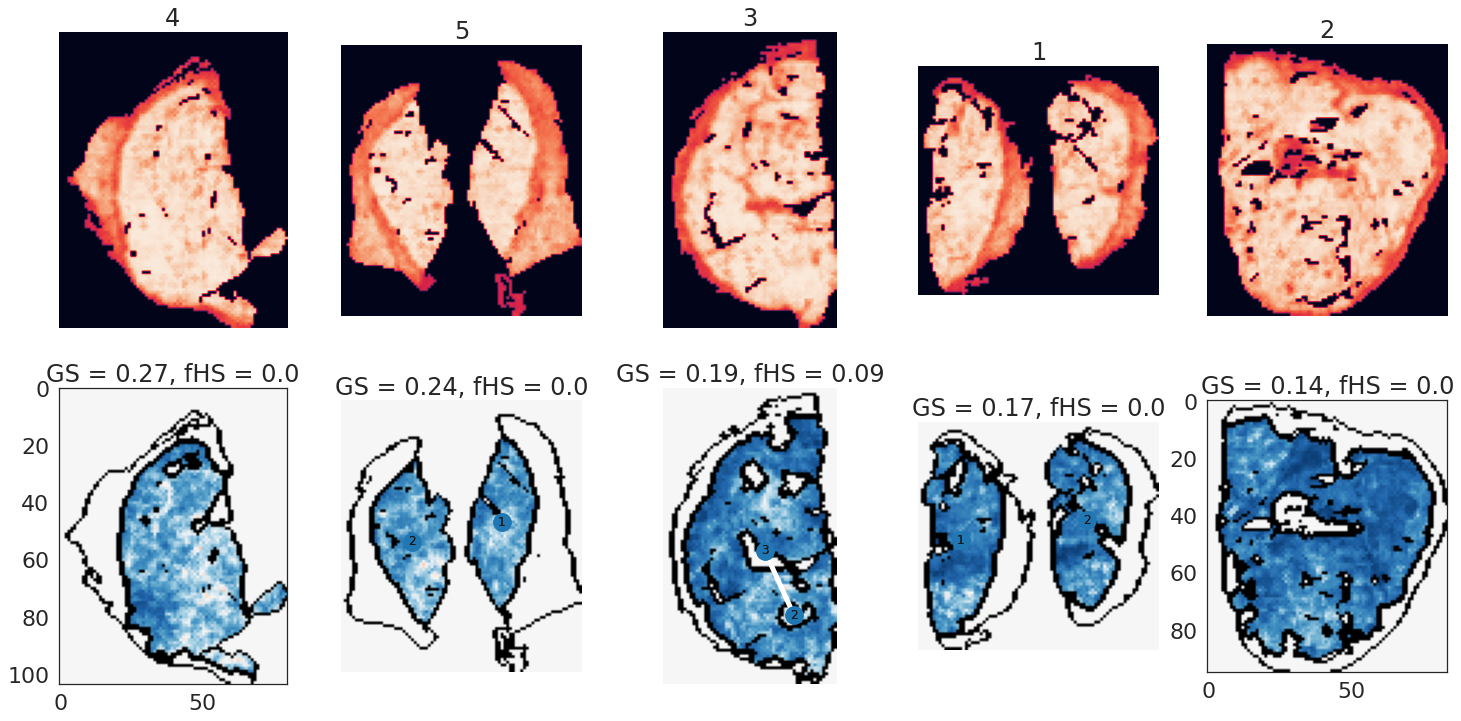

21
block_num
1    0.447251
3    0.426156
4    0.255785
5    0.320016
Name: smoothed_prob_g4_not_g2, dtype: float64
Max Entry: False,   GS 0.45
other slides: F 2; T 1



match
Detected Homogeneity, Consistent With Majority
found match: (3, 4)
no edges detected for JACKSON CASE 21 SLIDE 5_Scan1


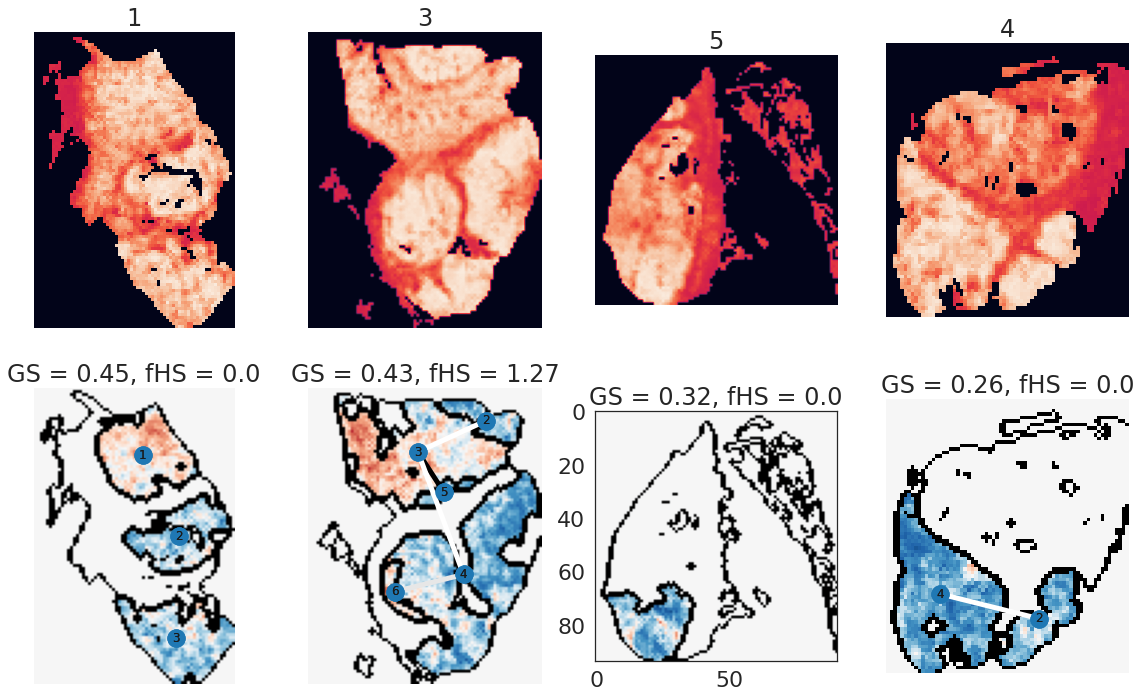

6
block_num
4    0.487019
5    0.647519
6    0.519607
9    0.556282
Name: smoothed_prob_g4_not_g2, dtype: float64
Max Entry: False,   GS 0.65
other slides: F 2; T 1



match
Detected Homogeneity, Consistent With Majority
no edges detected for JACKSON CASE 6 SLIDE 6_Scan1
no edges detected for JACKSON CASE 6 SLIDE 4_Scan1


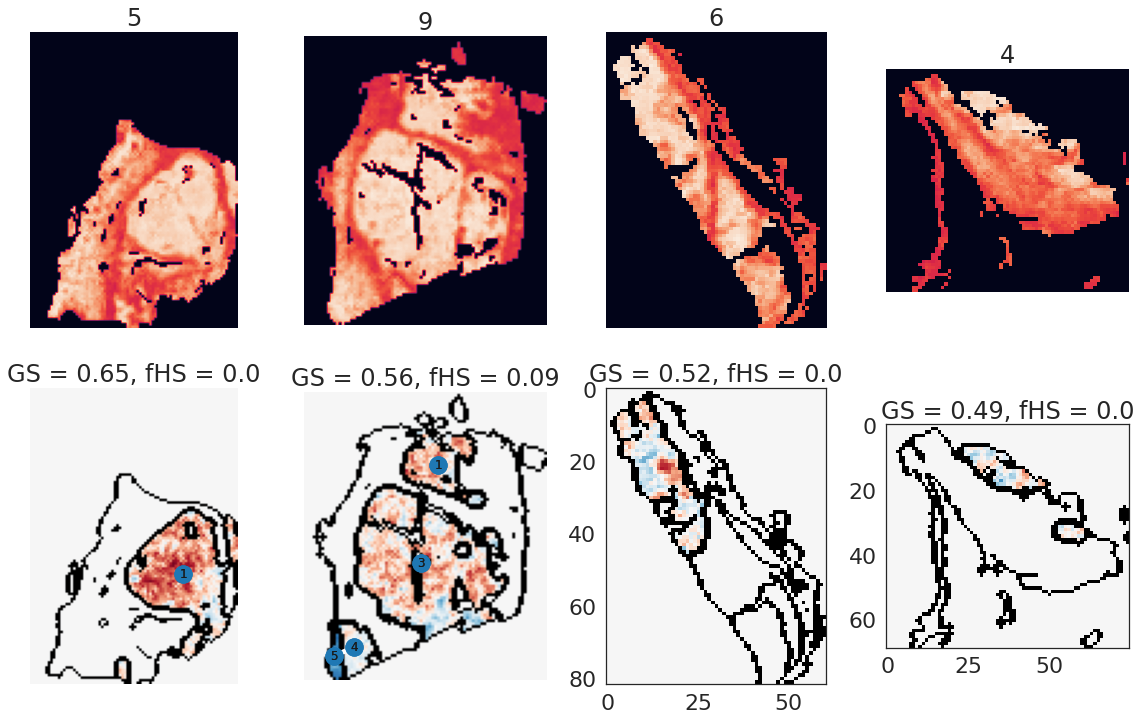

23
block_num
1    0.195611
2    0.256758
3    0.514797
5    0.168460
Name: smoothed_prob_g4_not_g2, dtype: float64
Max Entry: True,   GS 0.51
other slides: F 0; T 3



match
Detected Heterogeneity, Consistent With Majority
found match: (1, 3)
found match: (3, 4)
found match: (3, 6)
found match: (1, 5)
found match: (1, 3)


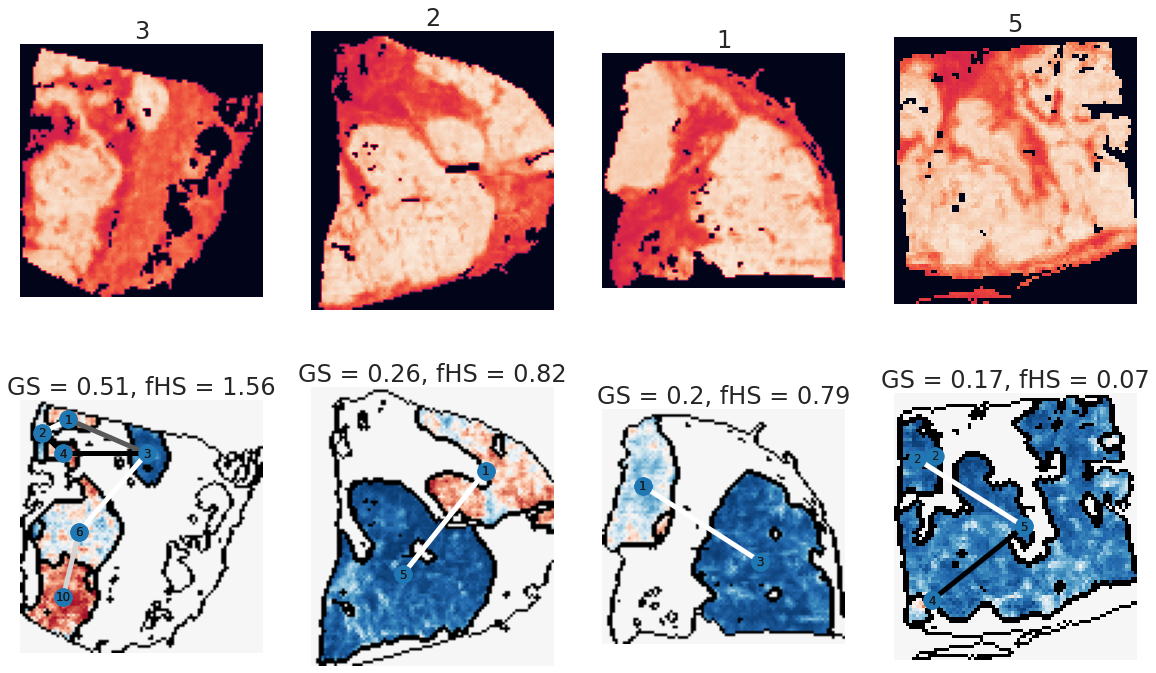

26
block_num
1    0.722803
2    0.685820
3    0.802725
4    0.697163
5    0.763379
Name: smoothed_prob_g4_not_g2, dtype: float64
Max Entry: True,   GS 0.8
other slides: F 0; T 4



match
Detected Heterogeneity, Consistent With Majority
found match: (12, 15)


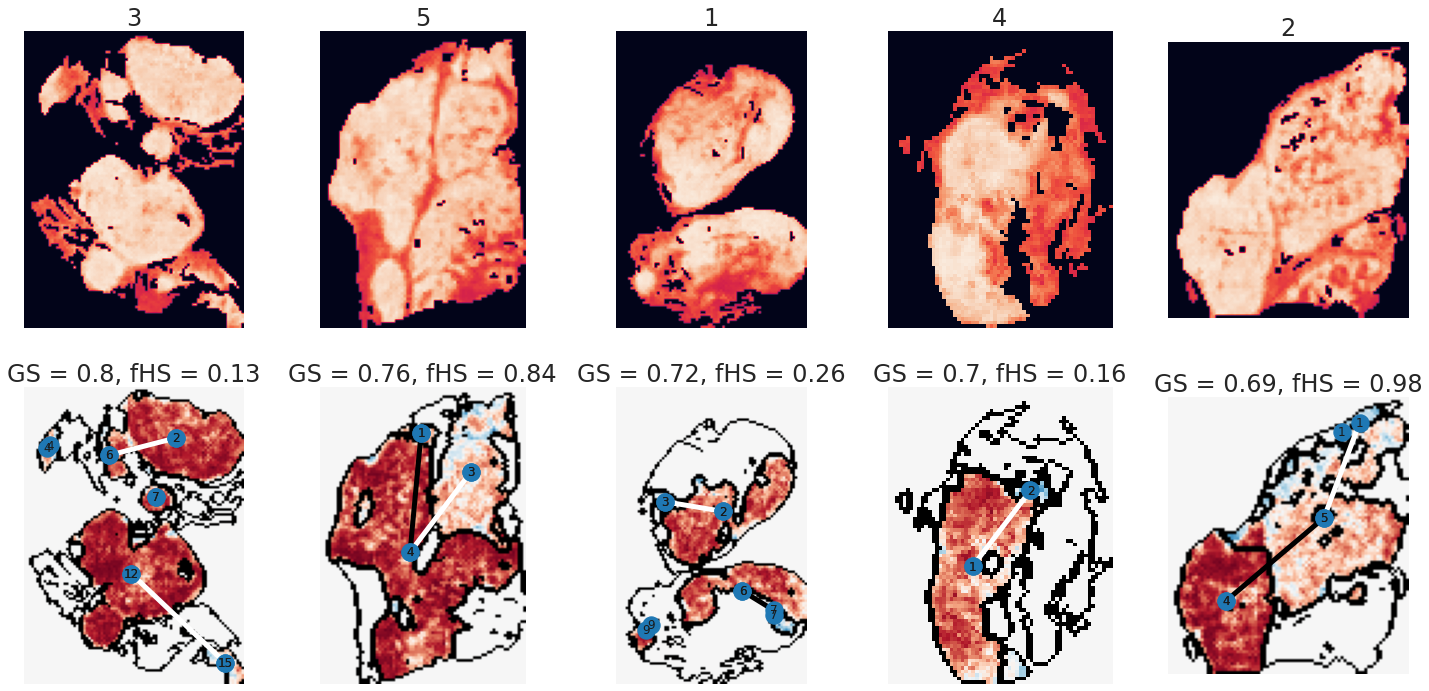

In [49]:
cases_of_interest = [19,21, 6, 23,26]
meta_results = {}
for case_num in cases_of_interest:
# for case_num in tilewise_nontil_info['case_num'].unique():
    print(case_num)
    subset = tilewise_nontil_info[tilewise_nontil_info['case_num'] == case_num]
    sub = dm.loc[case_num]
    print(sub['smoothed_prob_g4_not_g2'])
    blocks = sub.sort_values('smoothed_prob_g4_not_g2',ascending=False)[['smoothed_prob_g4_not_g2']].index.values
    
    if len(blocks) == 1:
        print(f'only found 1 block for case {case_num}, skipping plot')
        
    if len(blocks) > 1:

        set_rc(5*len(blocks),12, font_scale=2)


        flag = sub['smoothed_prob_g4_not_g2'].idxmax()

        submax = sub.drop(flag)['any_diff_edge'].value_counts()
        submax_avg = sub.drop(flag)['any_diff_edge'].mean()

        sub_true = (sub.drop(flag)['any_diff_edge'] == True).sum()
        sub_false = (sub.drop(flag)['any_diff_edge'] == False).sum()

        majority_sub = submax.idxmax()

        max_flag = sub.loc[flag,'any_diff_edge']
        max_score = sub.loc[flag,'smoothed_prob_g4_not_g2']

        print(f'Max Entry: {max_flag},   GS {max_score.round(2)}')

        try:
            print(f'other slides: F {sub_false}; T {sub_true}')
        except:
            print(f'other slides: {submax}')

        print('\n\n')
        if max_flag == majority_sub:
            print('match')
            if max_flag:
                descriptor = 'detected heterogeneity, consistent with majority'.title()
                print(descriptor)

            else:
                descriptor = 'detected homogeneity, consistent with majority'.title()
                print(descriptor)
            meta_results[uid] = True,descriptor, submax_avg
        else:
            print('==== MISMATCH')
            if max_flag:
                descriptor = 'detected heterogeneity in highest grade slide, but most others did not'.title()
                print(descriptor)
                meta_results[uid] = False, descriptor, submax_avg
            else:
                descriptor = 'detected homogeneity in highest grade slide, but most others did not'.title()
                print(descriptor)
                meta_results[uid] = False, descriptor, submax_avg


        fig, axes = plt.subplots(2,len(blocks), sharex=False, sharey=False)

        for idx,block_num in enumerate(blocks):
            ### RAGs
            #### Proximal
            axes[0,idx].set_title(block_num)
            
            gs = dm.loc[(case_num,block_num),'gs'].round(2)
            hs = dm.loc[(case_num,block_num),'fhs'].round(2)
            
            axes[1,idx].set_title(f'GS = {gs}, fHS = {hs}')
            try:
                uid = case_key.loc[(case_key['case_num'] == case_num) & (case_key['block_num'] == block_num)].index.values[0]
                ex_out = seg_out_agg[uid]
                input_df = ex_out['seg_df']
                heatmap = get_separated_heatmaps_simplified(input_df.reset_index().rename(columns={'tx':'x', 'ty':'y'}), col='smoothed_prob_tumor')

                axes[0,idx].imshow(heatmap)
                axes[0,idx].axis('off')

                mod_im = np.ma.masked_array(ex_out['seg_images']['all'], mask = np.isnan(ex_out['seg_images']['all'])).filled(0)
                mod_labels = np.ma.masked_array(ex_out['seg_out']['merged_labels'], mask = np.isnan(ex_out['seg_images']['all'])).filled(ex_out['seg_out']['merged_labels'].max()+1)
                label_clone = mod_labels.copy()

                if uid in edge_agg_pivot.index.levels[0].unique():
                    filtered_rags = prepare_distal_rag(seg_out_agg[uid], uid, edge_agg_pivot.loc[uid], min_segment_size=MIN_SEGMENT_SIZE)
                    for edge_type in ['proximal','distal']:
                        ax = axes[1,idx]
                        rag = filtered_rags[f'g_{edge_type}'].copy()
                        img_cmap='Reds_r'


                        g = rag.copy()
                        to_remove = []
                        for node_name in g.nodes:
                            if g.nodes[node_name]['pixel count'] < MIN_SEGMENT_SIZE:
                                to_remove.append(node_name)
    #                             print(f'removing {node_name}')
                        for node_name in to_remove:
                            g.remove_node(node_name)

                        overlay_copy = np.copy(mod_im)
                        overlay_copy[~((label_clone == 0) | (label_clone == label_clone.max()))] = 1-overlay_copy[~((label_clone == 0) | (label_clone == label_clone.max()))]
                        overlay_copy[(label_clone == label_clone.max())] = 0.5
                        overlay_copy[(label_clone == 0)] = 0.5


                        # version issue?
                        overlay_copy = np.repeat(np.expand_dims(overlay_copy, -1), 3, -1)

    #                     print('trying to plot rag')
                        lc = graph.show_rag(label_clone, g, overlay_copy, border_color='black', 
                                            edge_width=5,
                                            img_cmap='RdBu', edge_cmap='Greys', ax=ax)

                        flipped_centroids = {node_key: (y,x) for node_key, (x,y) in nx.get_node_attributes(g,'centroid').items()}  
                        edge_colors = nx.get_edge_attributes(g,'weight').values()
    #                     print('trying to plot edges')
                        nx.draw(g, flipped_centroids, ax=ax, edge_color=edge_colors, edge_vmin=0, edge_vmax=1.75, with_labels=True)
            #             plt.savefig(f'./overlays/{uid}_{edge_type}_rag_no_overlay_centered_RdBu.pdf', bbox_inches='tight')
                else:
                    print(f'no edges detected for {uid}')
                    ax = axes[1,idx]


                    img_cmap='Reds_r'

                    rag = seg_out_agg[uid]['rag']
                    g = rag.copy()
                    to_remove = []
                    for node_name in g.nodes:
                        if g.nodes[node_name]['pixel count'] < MIN_SEGMENT_SIZE:
                            to_remove.append(node_name)
    #                         print(f'removing {node_name}')
                    for node_name in to_remove:
                        g.remove_node(node_name)




                    overlay_copy = np.copy(mod_im)
                    overlay_copy[~((label_clone == 0) | (label_clone == label_clone.max()))] = 1-overlay_copy[~((label_clone == 0) | (label_clone == label_clone.max()))]
                    overlay_copy[(label_clone == label_clone.max())] = 0.5
                    overlay_copy[(label_clone == 0)] = 0.5
                    overlay_copy = np.repeat(np.expand_dims(overlay_copy, -1), 3, -1)

    #                 print('trying to plot rag')
                    lc = graph.show_rag(label_clone, g, overlay_copy, border_color='black', 
                                        edge_width=5,
                                        img_cmap='RdBu', edge_cmap='Greys', ax=ax)

        #             axes[1,idx].imshow(overlay_copy, cmap='RdBu', vmin=0, vmax=1)

            except Exception as e:
                print(e)
                print('no edge?')

        plt.show()


12
block_num
1    0.632643
2    0.481060
4    0.532181
5    0.443151
6    0.541337
Name: smoothed_prob_g4_not_g2, dtype: float64
Max Entry: True,   GS 0.63
other slides: F 1; T 3



match
Detected Heterogeneity, Consistent With Majority
no edges detected for JACKSON CASE 12 SLIDE 2_Scan1
found match: (2, 3)
found match: (2, 8)
found match: (2, 6)
found match: (9, 7)


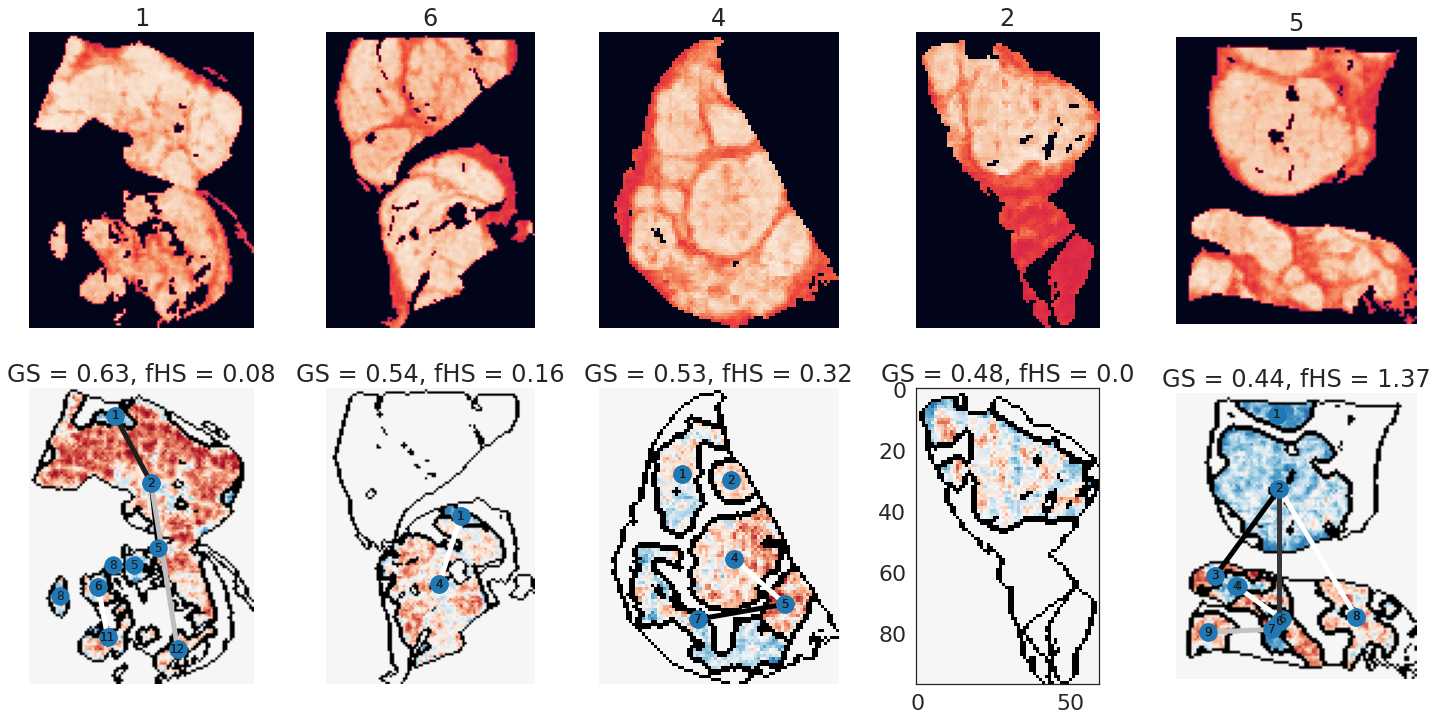

28
block_num
1    0.290663
2    0.348619
3    0.203884
5    0.235620
Name: smoothed_prob_g4_not_g2, dtype: float64
Max Entry: False,   GS 0.35
other slides: F 0; T 3



==== MISMATCH
Detected Homogeneity In Highest Grade Slide, But Most Others Did Not
no edges detected for JACKSON CASE 28 SLIDE 2_Scan1
found match: (3, 6)
found match: (5, 4)


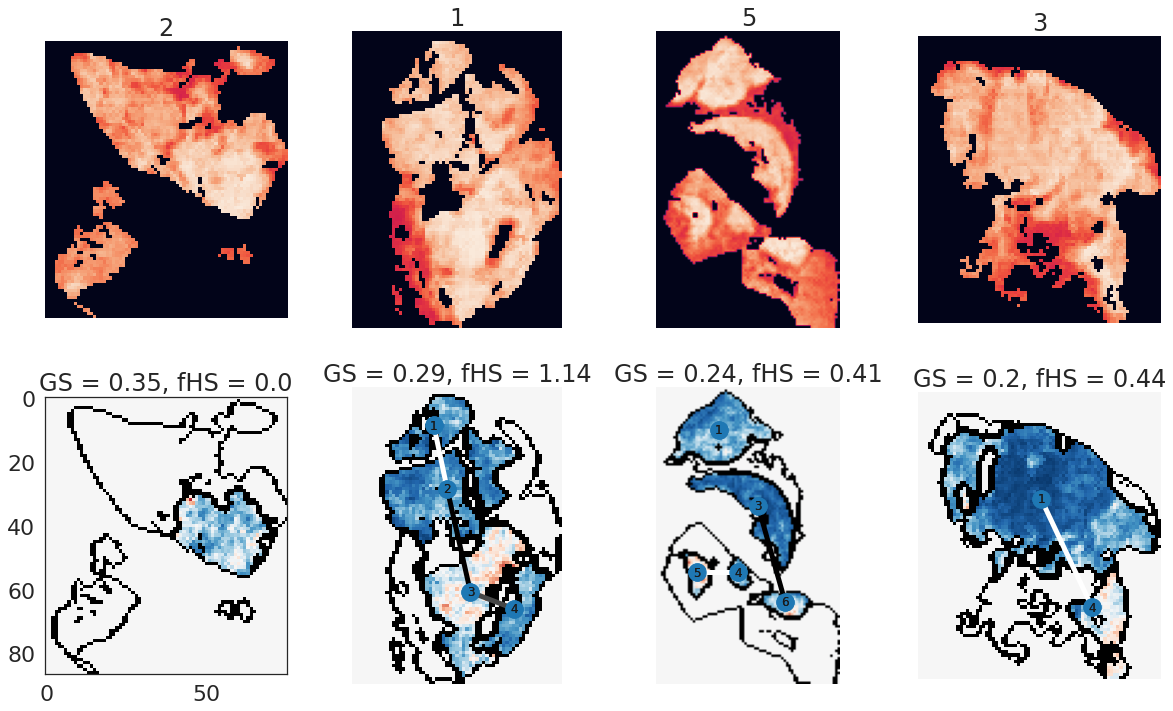

In [50]:
cases_of_interest = [12,28]
meta_results = {}
for case_num in cases_of_interest:
# for case_num in tilewise_nontil_info['case_num'].unique():
    print(case_num)
    subset = tilewise_nontil_info[tilewise_nontil_info['case_num'] == case_num]
    sub = dm.loc[case_num]
    print(sub['smoothed_prob_g4_not_g2'])
    blocks = sub.sort_values('smoothed_prob_g4_not_g2',ascending=False)[['smoothed_prob_g4_not_g2']].index.values
    
    if len(blocks) == 1:
        print(f'only found 1 block for case {case_num}, skipping plot')
        
    if len(blocks) > 1:

        set_rc(5*len(blocks),12, font_scale=2)


        flag = sub['smoothed_prob_g4_not_g2'].idxmax()

        submax = sub.drop(flag)['any_diff_edge'].value_counts()
        submax_avg = sub.drop(flag)['any_diff_edge'].mean()

        sub_true = (sub.drop(flag)['any_diff_edge'] == True).sum()
        sub_false = (sub.drop(flag)['any_diff_edge'] == False).sum()

        majority_sub = submax.idxmax()

        max_flag = sub.loc[flag,'any_diff_edge']
        max_score = sub.loc[flag,'smoothed_prob_g4_not_g2']

        print(f'Max Entry: {max_flag},   GS {max_score.round(2)}')

        try:
            print(f'other slides: F {sub_false}; T {sub_true}')
        except:
            print(f'other slides: {submax}')

        print('\n\n')
        if max_flag == majority_sub:
            print('match')
            if max_flag:
                descriptor = 'detected heterogeneity, consistent with majority'.title()
                print(descriptor)

            else:
                descriptor = 'detected homogeneity, consistent with majority'.title()
                print(descriptor)
            meta_results[uid] = True,descriptor, submax_avg
        else:
            print('==== MISMATCH')
            if max_flag:
                descriptor = 'detected heterogeneity in highest grade slide, but most others did not'.title()
                print(descriptor)
                meta_results[uid] = False, descriptor, submax_avg
            else:
                descriptor = 'detected homogeneity in highest grade slide, but most others did not'.title()
                print(descriptor)
                meta_results[uid] = False, descriptor, submax_avg


        fig, axes = plt.subplots(2,len(blocks), sharex=False, sharey=False)

        for idx,block_num in enumerate(blocks):
            ### RAGs
            #### Proximal
            axes[0,idx].set_title(block_num)
            
            gs = dm.loc[(case_num,block_num),'gs'].round(2)
            hs = dm.loc[(case_num,block_num),'fhs'].round(2)
            
            axes[1,idx].set_title(f'GS = {gs}, fHS = {hs}')
            try:
                uid = case_key.loc[(case_key['case_num'] == case_num) & (case_key['block_num'] == block_num)].index.values[0]
                ex_out = seg_out_agg[uid]
                input_df = ex_out['seg_df']
                heatmap = get_separated_heatmaps_simplified(input_df.reset_index().rename(columns={'tx':'x', 'ty':'y'}), col='smoothed_prob_tumor')

                axes[0,idx].imshow(heatmap)
                axes[0,idx].axis('off')

                mod_im = np.ma.masked_array(ex_out['seg_images']['all'], mask = np.isnan(ex_out['seg_images']['all'])).filled(0)
                mod_labels = np.ma.masked_array(ex_out['seg_out']['merged_labels'], mask = np.isnan(ex_out['seg_images']['all'])).filled(ex_out['seg_out']['merged_labels'].max()+1)
                label_clone = mod_labels.copy()

                if uid in edge_agg_pivot.index.levels[0].unique():
                    filtered_rags = prepare_distal_rag(seg_out_agg[uid], uid, edge_agg_pivot.loc[uid], min_segment_size=MIN_SEGMENT_SIZE)
                    for edge_type in ['proximal','distal']:
                        ax = axes[1,idx]
                        rag = filtered_rags[f'g_{edge_type}'].copy()
                        img_cmap='Reds_r'


                        g = rag.copy()
                        to_remove = []
                        for node_name in g.nodes:
                            if g.nodes[node_name]['pixel count'] < MIN_SEGMENT_SIZE:
                                to_remove.append(node_name)
    #                             print(f'removing {node_name}')
                        for node_name in to_remove:
                            g.remove_node(node_name)

                        overlay_copy = np.copy(mod_im)
                        overlay_copy[~((label_clone == 0) | (label_clone == label_clone.max()))] = 1-overlay_copy[~((label_clone == 0) | (label_clone == label_clone.max()))]
                        overlay_copy[(label_clone == label_clone.max())] = 0.5
                        overlay_copy[(label_clone == 0)] = 0.5


                        # version issue?
                        overlay_copy = np.repeat(np.expand_dims(overlay_copy, -1), 3, -1)

    #                     print('trying to plot rag')
                        lc = graph.show_rag(label_clone, g, overlay_copy, border_color='black', 
                                            edge_width=5,
                                            img_cmap='RdBu', edge_cmap='Greys', ax=ax)

                        flipped_centroids = {node_key: (y,x) for node_key, (x,y) in nx.get_node_attributes(g,'centroid').items()}  
                        edge_colors = nx.get_edge_attributes(g,'weight').values()
    #                     print('trying to plot edges')
                        nx.draw(g, flipped_centroids, ax=ax, edge_color=edge_colors, edge_vmin=0, edge_vmax=1.75, with_labels=True)
            #             plt.savefig(f'./overlays/{uid}_{edge_type}_rag_no_overlay_centered_RdBu.pdf', bbox_inches='tight')
                else:
                    print(f'no edges detected for {uid}')
                    ax = axes[1,idx]


                    img_cmap='Reds_r'

                    rag = seg_out_agg[uid]['rag']
                    g = rag.copy()
                    to_remove = []
                    for node_name in g.nodes:
                        if g.nodes[node_name]['pixel count'] < MIN_SEGMENT_SIZE:
                            to_remove.append(node_name)
    #                         print(f'removing {node_name}')
                    for node_name in to_remove:
                        g.remove_node(node_name)




                    overlay_copy = np.copy(mod_im)
                    overlay_copy[~((label_clone == 0) | (label_clone == label_clone.max()))] = 1-overlay_copy[~((label_clone == 0) | (label_clone == label_clone.max()))]
                    overlay_copy[(label_clone == label_clone.max())] = 0.5
                    overlay_copy[(label_clone == 0)] = 0.5
                    overlay_copy = np.repeat(np.expand_dims(overlay_copy, -1), 3, -1)

    #                 print('trying to plot rag')
                    lc = graph.show_rag(label_clone, g, overlay_copy, border_color='black', 
                                        edge_width=5,
                                        img_cmap='RdBu', edge_cmap='Greys', ax=ax)

        #             axes[1,idx].imshow(overlay_copy, cmap='RdBu', vmin=0, vmax=1)

            except Exception as e:
                print(e)
                print('no edge?')

        plt.show()


In [39]:
submax

Series([], Name: any_diff_edge, dtype: int64)

In [40]:
sub.

,block_num,unique_id,x,y,Unnamed: 0,prob_tumor,prob_g4_not_g2,smoothed_prob_tumor,smoothed_prob_g4_not_g2,tumor_seg_label,...,at_least_3_het,slide_seg_max,slide_seg_maxes_05_area_frac_min,slide_seg_maxes_10_area_frac_min,slide_seg_maxes_25_area_frac_min,het_score_group,grade_score,fhs,ths,gs
case_num,,,,,,,,,,,,,,,,,,,,,
19,1,JACKSON CASE 19 SLIDE 1_Scan1,34.791264,37.245517,202344.222069,0.802989,0.173485,0.800521,0.172231,7.103908,...,False,0.178854,0.178854,0.178854,0.178854,homogeneous,0.172231,0.000000,0.000000,0.172231
19,2,JACKSON CASE 19 SLIDE 2_Scan1,38.894723,46.988160,206839.699871,0.798687,0.146181,0.796576,0.140741,9.000000,...,False,0.140741,0.140741,0.140741,0.140741,homogeneous,0.140741,0.000000,0.000000,0.140741
19,3,JACKSON CASE 19 SLIDE 3_Scan1,34.756577,56.016836,211541.157839,0.828678,0.191350,0.825250,0.187414,17.000000,...,False,0.426964,0.181590,0.181590,0.181590,lower_het_score,0.187414,0.087775,0.998597,0.187414
19,4,JACKSON CASE 19 SLIDE 4_Scan1,43.512539,61.064655,215361.034091,0.851772,0.273118,0.848202,0.271186,7.000000,...,False,0.271079,0.271079,0.271079,0.271079,homogeneous,0.271186,0.000000,0.000000,0.271186
19,5,JACKSON CASE 19 SLIDE 5_Scan1,40.415482,47.172722,218654.287520,0.860792,0.243869,0.856370,0.242285,3.945761,...,False,0.250415,0.250415,0.250415,0.250415,homogeneous,0.242285,0.000000,0.000000,0.242285
